# CarND Advanced Lane Finding

## Udacity Self Driving Car Engineer Nanodegree - Project 4

The goal of this project is to develop a pipeline to process a video stream from a forward-facing camera mounted on the front of a car, and output an annotated video which identifies:
- The positions of the lane lines 
- The location of the vehicle relative to the center of the lane
- The radius of curvature of the road

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

### Step 1: Distortion Correction

The first step in the project is to remove any distortion from the images by calculating the camera calibration matrix and distortion coefficients using a series of images of a chessboard.

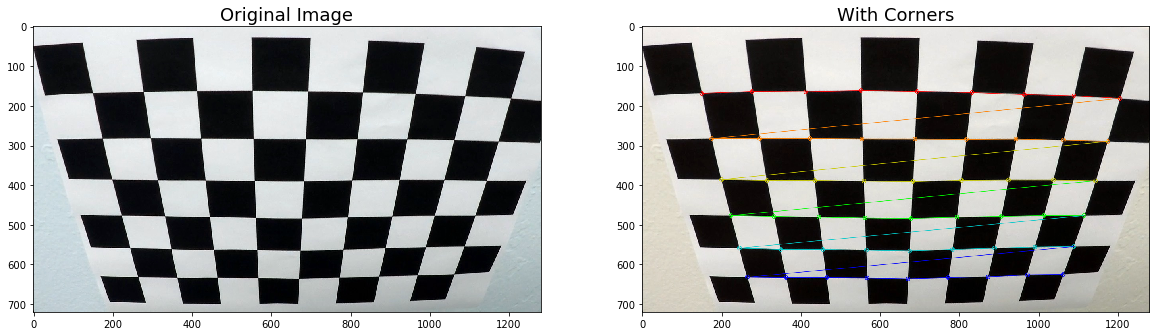

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

cal_images = glob.glob('camera_cal/calibration2.jpg')

for idx, fname in enumerate(cal_images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

Next I will define a function `undistort()` which uses the calculate camera calibration matrix and distortion coefficients to remove distortion from an image and output the undistorted image.

In [3]:
# Remove distortion from images
def undistort(image):
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

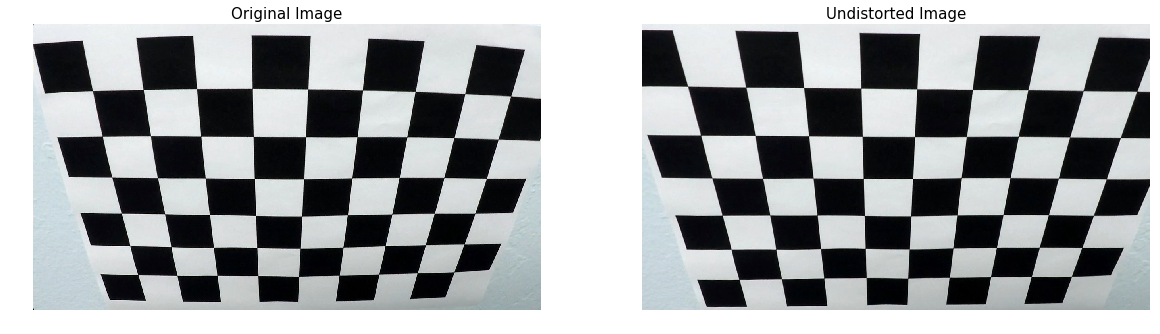

In [4]:
f = None
ax1 = None
ax2 = None
def graph(img1, img2, img1_label = 'Original Image', img2_label = 'Undistorted Image'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.axis('off')
    ax1.imshow(img1)
    ax1.set_title(img1_label, fontsize=15)
    ax2.axis('off')
    ax2.imshow(img2)
    ax2.set_title(img2_label, fontsize=15)

img = cv2.imread('camera_cal/calibration2.jpg')
undistorted = undistort(img)

# Visualize undistortion
graph(img,undistorted)

### Step 2: Perspective Transform

In this step I will define a function `overhead_view()` which transforms the undistorted image to an overhead view of the road which focuses only on the lane lines and displays them in such a way that they appear to be relatively parallel to eachother. This will make it easier later on to fit polynomials to the lane lines and measure the curvature.

In [5]:
# Perform perspective transform
def overhead_view(img):
    undist = undistort(img) 
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped


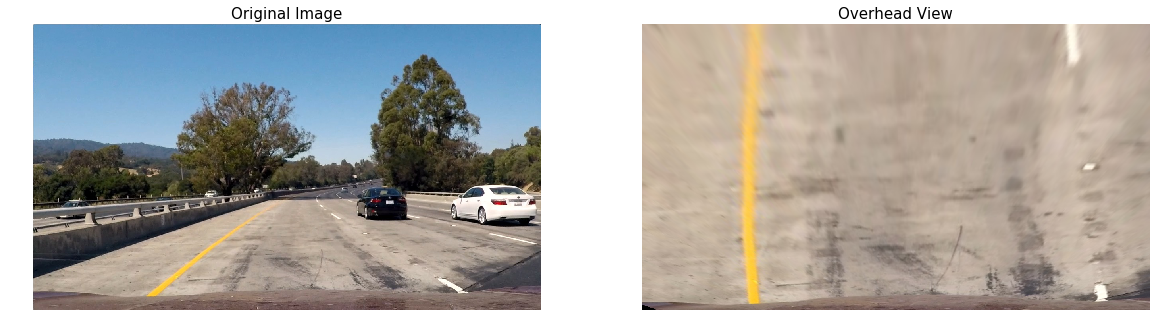

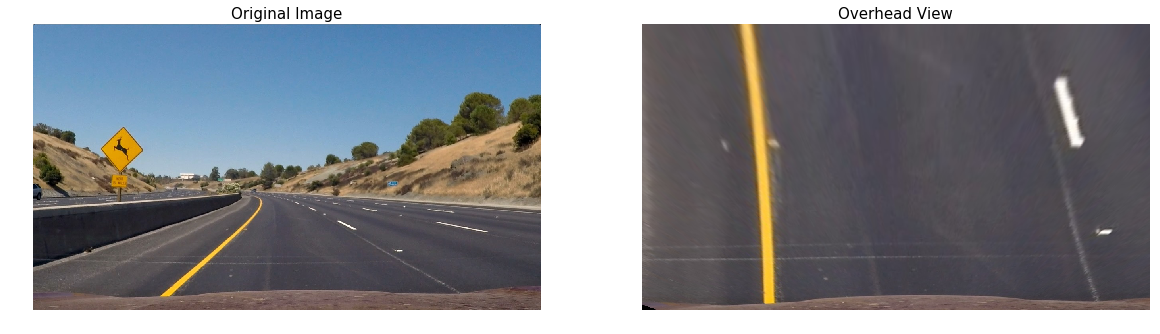

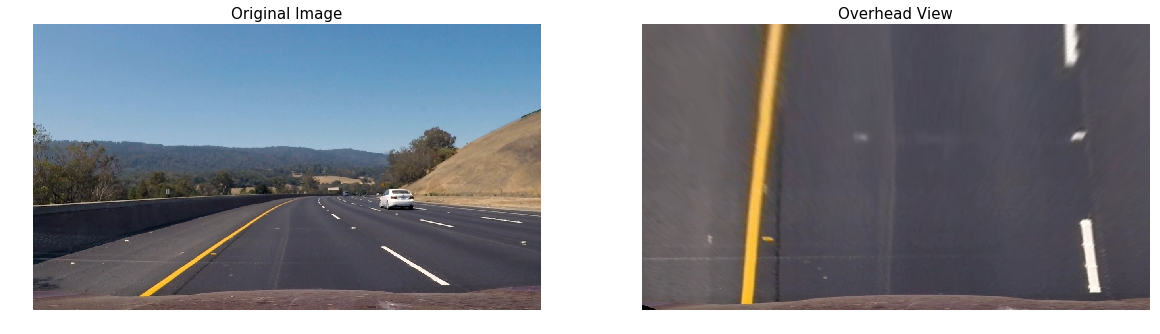

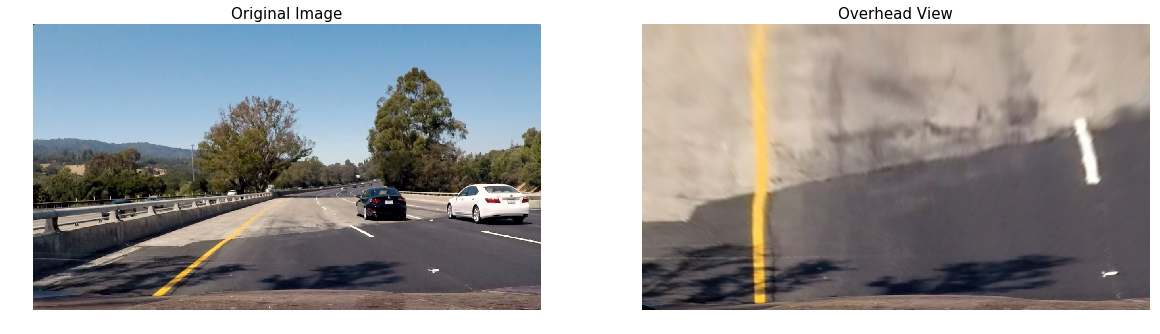

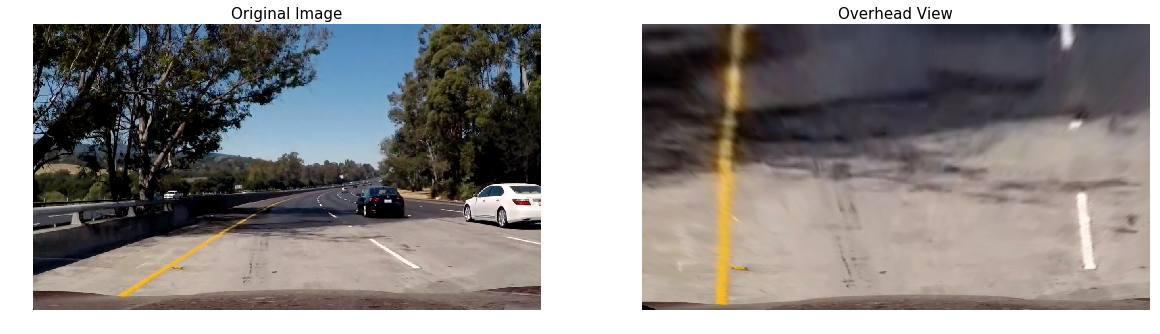

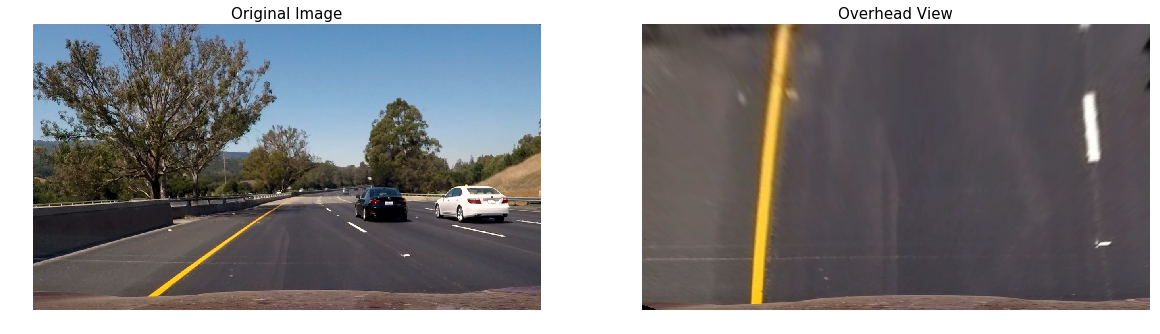

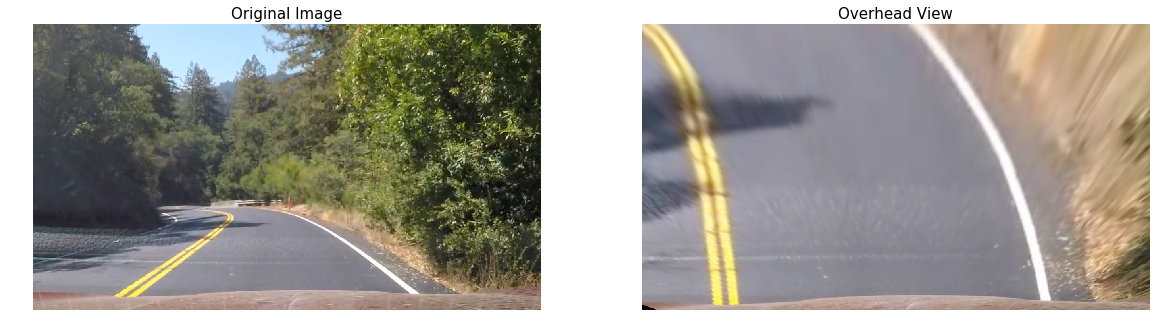

In [31]:
for filename in glob.glob('test_images/test*.jpg'):
    image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    undistorted = undistort(image)
    overhead = overhead_view(image)
    graph(image,overhead,'Original Image','Overhead View')


### Step 3: Apply Binary Thresholds

In this step I attempted to convert the warped image to different color spaces and create binary thresholded images which highlight only the lane lines and ignore everything else. 
I found that the following color channels and thresholds did a good job of identifying the lane lines in the provided test images:
- The S Channel from the HLS color space, with a min threshold of 180 and a max threshold of 255, did a fairly good job of identifying both the white and yellow lane lines, but did not pick up 100% of the pixels in either one, and had a tendency to get distracted by shadows on the road.
- The L Channel from the LUV color space, with a min threshold of 225 and a max threshold of 255, did an almost perfect job of picking up the white lane lines, but completely ignored the yellow lines.
- The B channel from the Lab color space, with a min threshold of 155 and an upper threshold of 200, did a better job than the S channel in identifying the yellow lines, but completely ignored the white lines. 

I chose to create a combined binary threshold based on the three above mentioned binary thresholds, to create one combination thresholded image which does a great job of highlighting almost all of the white and yellow lane lines.

**Note: The S binary threshold was left out of the final combined binary image and was not used in detecting lane lines because it added extra noise to the binary image and interfered with detecting lane lines accurately.**

In [151]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_threshold_binary(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    if ( len(img.shape) < 3 or (img.shape)[2] == 1):
        gray = img
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobelx = np.square(np.absolute(sobelx))
    abs_sobely = np.square(np.absolute(sobely))
    abs_sobelxy = np.sum((abs_sobelx, abs_sobely), axis=0)
    abs_sobelxy = np.sqrt(abs_sobelxy)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold_binary(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    if ( len(img.shape) < 3 or (img.shape)[2] == 1):
        gray = img
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradiant_dir = np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(gradiant_dir)
    binary_output[(gradiant_dir >= thresh[0]) & (gradiant_dir <= thresh[1])] = 1

    return binary_output

# Create binary thresholded images to isolate lane line pixels
def apply_thresholds(image, show=True):
    overhead = overhead_view(image)
    s_channel = cv2.cvtColor(overhead, cv2.COLOR_BGR2HLS)[:,:,2]
    l_channel = cv2.cvtColor(overhead, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(overhead, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    ## orig: 145,200 - 155,200  optimal: 160,255
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    ## orig: 215,255 - 225,255  optimal: 220,255
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    mag_binary = mag_threshold_binary(
        overhead, sobel_kernel=3, mag_thresh=(30,100))
    dir_binary = dir_threshold_binary(
        overhead, sobel_kernel=15, thresh=(0.2, 1.9))  # 0.7 - 1.3
    
    combined_binary = np.zeros_like(s_binary)
#    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    combined_binary[(l_binary == 1) | (s_binary == 1)] = 1

    mag_binary = mag_threshold_binary(
        combined_binary, sobel_kernel=3, mag_thresh=(30,100))
    dir_binary = dir_threshold_binary(
        combined_binary, sobel_kernel=15, thresh=(0.2, 1.9))  # 0.7 - 1.3

    if show == True:
        # Plotting thresholded images
#        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f, ((ax1, ax2, ax3,ax4), (ax5,ax6, ax7,ax8)) = plt.subplots(2, 4, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.axis('off')
        ax1.set_title('Original', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistort(image),cv2.COLOR_BGR2RGB))
        
        ax2.axis('off')
        ax2.set_title('Overhead', fontsize=16)
        ax2.imshow(cv2.cvtColor(overhead, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.axis('off')
        ax3.set_title('S binary', fontsize=16)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.axis('off')
        ax4.set_title('B binary', fontsize=16)
        ax4.imshow(b_binary, cmap='gray')
        
        ax5.axis('off')
        ax5.set_title('L binary', fontsize=16)
        ax5.imshow(l_binary, cmap='gray')

        ax6.axis('off')
        ax6.set_title('mag binary', fontsize=16)
        ax6.imshow(mag_binary, cmap='gray')

        ax7.axis('off')
        ax7.set_title('dir binary', fontsize=16)
        ax7.imshow(dir_binary, cmap='gray')

        ax8.axis('off')
        ax8.set_title('Combined binary', fontsize=16)
        ax8.imshow(combined_binary, cmap='gray')
    return combined_binary

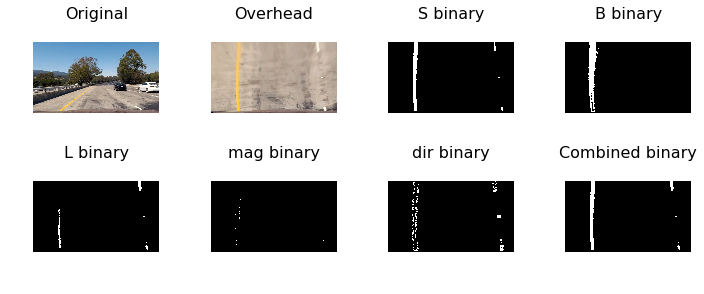

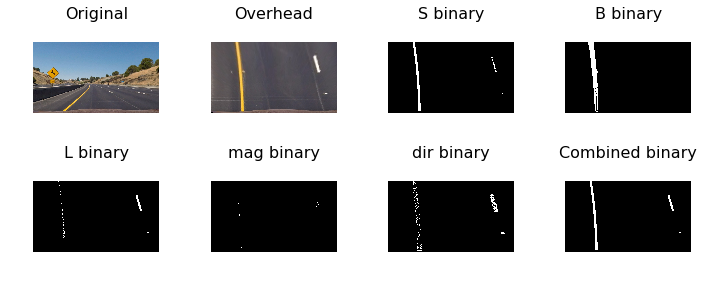

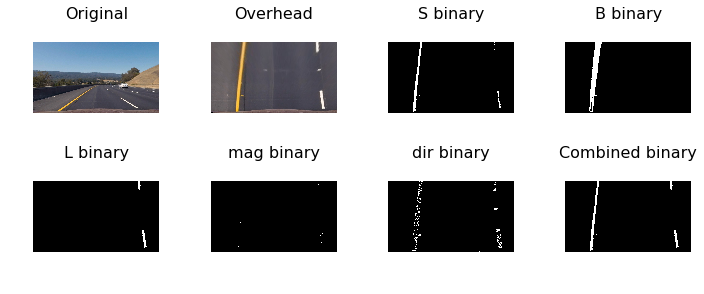

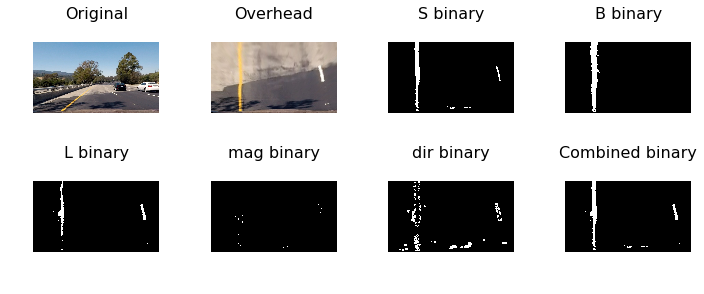

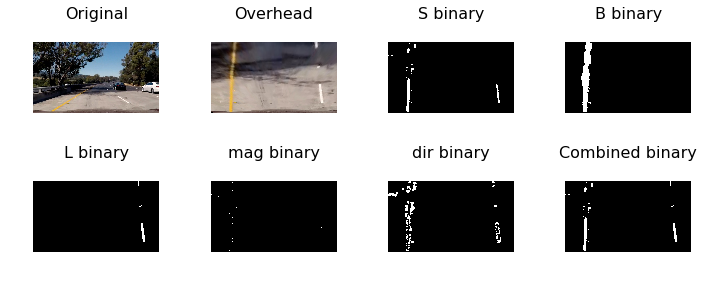

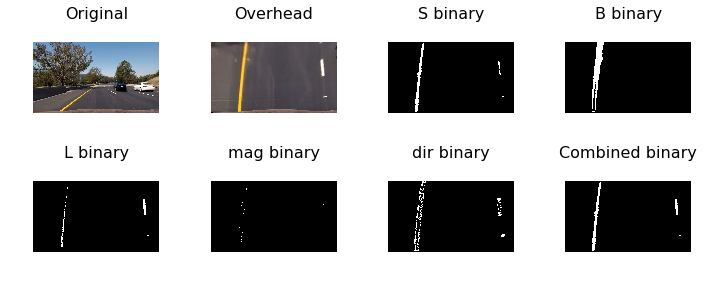

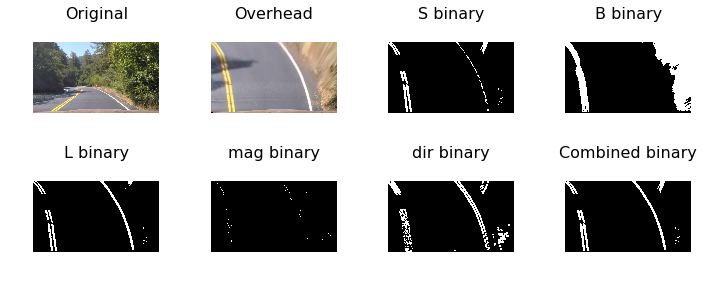

In [157]:
for filename in glob.glob('test_images/test*.jpg'):
# for filename in ['test_images/test1.jpg','test_images/test7.jpg']:
    image = cv2.imread(filename)
    apply_thresholds(image,show=True)

### Steps 4, 5 and 6: Fitting a polynomial to the lane lines, calculating vehicle position and radius of curvature:

At this point I was able to use the combined binary image to isolate lane line pixels and fit a polynomial to each of the lane lines. The space in between the identified lane lines is filled in to highlight the driveable area in the lane. The position of the vehicle was measured by taking the average of the x intercepts of each line.

The equation for calculating radius of curvature was discovered at this page: http://www.intmath.com/applications-differentiation/8-radius-curvature.php

In the function `fill_lane()` below, lane lines are detected by identifying peaks in a histogram of the image and detecting nonzero pixels in close proximity to the peaks. 

In [154]:
def compute_curves(img):
    combined_binary = apply_thresholds(img, show=False)
    rightx = []
    righty = []
    leftx = []
    lefty = []
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)

    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    return leftx,lefty,left_fitx,rightx,righty,right_fitx


In [155]:
def compute_avg_curvature(image):
    (leftx,lefty,left_fitx,rightx,righty,right_fitx) = compute_curves(image)

    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7091/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*right_fit_cr[0])
    return int((left_curverad + right_curverad)/2)



def overhead_view_with_curves(image):
    overhead = overhead_view(image)
    (leftx,lefty,left_fitx,rightx,righty,right_fitx) = compute_curves(img)
    s = image.shape
    x1 = left_fitx[0]
    y1 = s[0] - lefty[0]
    pt1 = (int(x1), int(s[0]-y1))
    pt2 = (int(left_fitx[100]), int(s[0]-lefty[100]))
    return overhead


def fill_lane(image,show=False):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    combined_binary = apply_thresholds(image, show=False)
    (leftx,lefty,left_fitx,rightx,righty,right_fitx) = compute_curves(image)

    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7091/700 # meteres per pixel in x dimension

    # Calculate the position of the vehicle
    center = abs(640 - ((rightx[-1]+leftx[-1])/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)

    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), 1, newwarp, 0.5, 0)

    if center < 640:
        direction = 'left '
        sig = '<-'
    else:
        direction = 'right'
        sig = '->'

    txt = 'Vehicle is '+direction+' of center (m):  {:.2f} '+sig+' '
    cv2.putText(result, txt.format(center*xm_per_pix),(250,50), 
                cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),4,cv2.LINE_AA)
    cv2.putText(result, 'Radius of curvature is (m): {}'.format(compute_avg_curvature(image)),(250,100), 
                cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),4,cv2.LINE_AA)

    
    
    if( show == True):
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
        f.tight_layout()
        ax1.axis('off')
        ax1.imshow(cv2.cvtColor((overhead_view_with_curves(image)), cv2.COLOR_BGR2RGB))
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(0, 720)
        ax1.plot(left_fitx, lefty, color='blue', linewidth=3)
        ax1.plot(right_fitx, righty, color='blue', linewidth=3)
        ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
        ax1.invert_yaxis() # to visualize as we do the images

        ax2.axis('off')
        ax2.imshow(result)
        ax2.set_xlim(0, 1280)
        ax2.set_ylim(0, 720)
        ax2.set_title('Filled Lane Lines', fontsize=16)
        ax2.invert_yaxis() # to visualize as we do the images

    return result



### Step 7: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

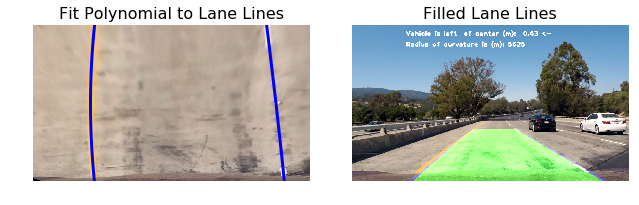

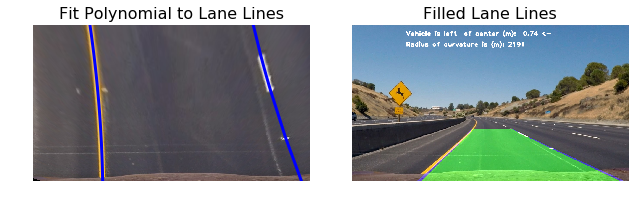

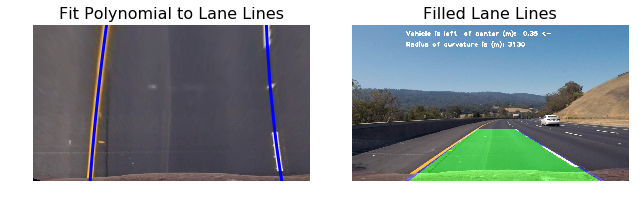

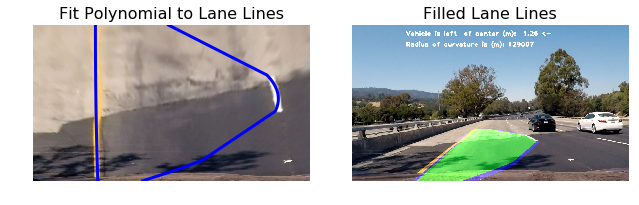

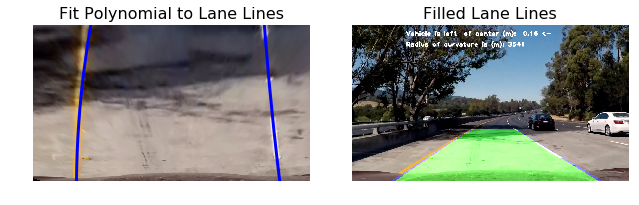

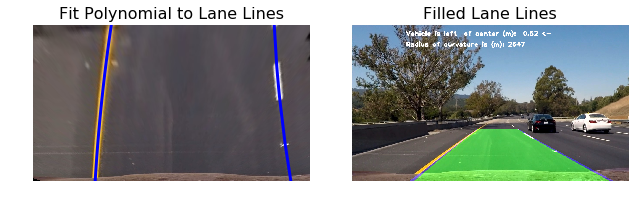

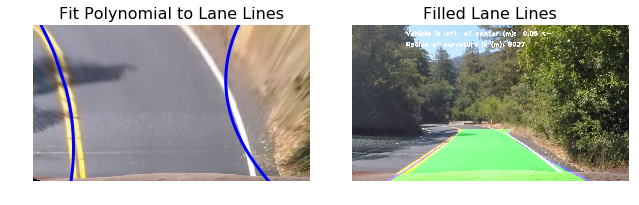

In [156]:
for filename in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    filled = fill_lane(image,show=True)


## Video Processing Pipeline:

First I am going to establish a class Line() for the lines to store attributes about the lane lines from one frame to the next. Inside the class I will define several functions which will be used to detect the pixels belonging to each lane line.

In [115]:
class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

Next I create a function `process_vid()` which processes a video frame by frame and outputs an annotated video with lane lines, radius of curvature and distance from center.

The video processing pipeline is very similar to the `fill_lanes()` function established earlier in the report, except that the video pipeline stores information about the lane lines across frames to average the lane positions and ensure a smooth output which is less impacted by outliers.

The video pipeline also knows whether or not the lane line was detected in the previous frame, and if it was, it only checks for lane pixels in a tight window around the previous polynomial, ensuring a high confidence detection. If the lane line was not detected in the previous frames (and for the first 5 frames of the video) The pipeline performs the same search which was performed in the fill_lanes() function based on identifying peaks in a histogram.

In [116]:
# Video Processing Pipeline
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    return fill_lane(image,show=False)
    
    
def process_vid_other(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    # orig: 145,200  optimal: 160,255
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    # orig: 215,255  optimal: 220,255
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)
           
    if Right.found == False: # Perform blind search for right lane lines
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
#    rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)
#    leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

In [117]:
Left = Line()
Right = Line()
video_output = 'result.mp4'
vid = VideoFileClip(filename="project_video.mp4",audio=False)
clip1 = vid.subclip(0,2)
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 98%|█████████▊| 50/51 [00:40<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



* The following is the result of the video pipeline being run on the project video.

In [118]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [121]:
Left = Line()
Right = Line()
challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4",audio=False)
challenge_clip = clip1.fl_image(process_vid_other) 
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|██████████| 485/485 [01:41<00:00,  4.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



Next is the result of the pipeline on a harder challenge video

In [122]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))

In [119]:
Left = Line()
Right = Line()
challenge_output = 'harder_challenge_result.mp4'
clip1 = VideoFileClip("harder_challenge_videooo.mp4",audio=False)
challenge_clip = clip1.fl_image(process_vid_other) 
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_result.mp4
[MoviePy] Writing video harder_challenge_result.mp4


 99%|█████████▉| 131/132 [00:52<00:00,  2.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_result.mp4 



In [120]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('harder_challenge_result.mp4'))